In [1]:
from brainseg2d import *

# 1) Define your path directory variables

In [2]:
images_dir = "./Data"
masks_dir = "./Masks"
models_dir = "./Models"
filename_model = "hpc.pth"

In [3]:
path_to_model = models_dir+"/"+filename_model

### To train the model on your images and masks (ROIs), use cells in sections 2) or 3) for either a fast or custom training pipeline, respectively. To make the model generate new ROIs on unseen images, go to section 4).

# 2) Fast training pipeline

### 2.1) Train model with the automated workflow

In [ ]:
model = train_segmentation_workflow(
    images_dir=images_dir,
    masks_dir=masks_dir,
    train_ratio=0.8,    # 80% train, 20% val
    target_min=300,     # want at least 200 examples
    target_max=500,
    down_ratio=0.25,    # downsample images to 25% original size
    num_epochs=100,
    learning_rate=1e-4,
    load_model=False,
    model_path=None,
    save_checkpoint_path=path_to_model
)

# 3) Custom training pipeline

In [ ]:
print("Using device:", device)

### 3.1) Parse Metadata & determine number of classes

In [4]:
orig_height, orig_width, min_channels = get_image_metadata(images_dir)
num_classes = get_num_classes(masks_dir)

print("Original Height:", orig_height)
print("Original Width: ", orig_width)
print("Minimum Channels among images:", min_channels)
print("Number of ROIs:", num_classes - 1)     # except class==0, which is the background (hence the "-1")

Original Height: 3117
Original Width:  5087
Minimum Channels among images: 4
Number of ROIs: 5


### 3.2) Determine downsample dimensions, aug. multiplier, and batch size

In [5]:
down_ratio    = 0.25
target_min    = 300
target_max    = 500

down_height, down_width = get_downsampled_dims(orig_height, orig_width, down_ratio)
print("Downsampled Height:", down_height)
print("Downsampled Width: ", down_width)

# Count how many base images there are
image_paths = glob.glob(os.path.join(images_dir, "*.tif"))
num_images  = len(image_paths)
print("Found", num_images, "images")

aug_mult = compute_augment_multiplier(num_images, target_min=target_min, target_max=target_max)
print("Augment Multiplier:", aug_mult)

batch_size = determine_batch_size()
print("Batch size (auto):", batch_size)

Downsampled Height: 768
Downsampled Width:  1280
Found 106 images
Augment Multiplier: 2
Batch size (auto): 8


### 3.3) Build dataset with augmentation pipelines

In [6]:
train_aug, val_aug = get_augmentation_pipelines(down_height, down_width)

### 3.4) Build dataset

In [7]:
# Create a dataset without specifying an augmentation pipeline (yet).
full_dataset = ImageDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    aug_pipeline=None,        # We'll assign after split 
    augment_multiplier=aug_mult,
    num_channels=min_channels
)
print("Full dataset length:", len(full_dataset))

Full dataset length: 212


### 3.5) Split dataset into train & validation

In [8]:
train_dataset_subset, val_dataset_subset = split_dataset(full_dataset, train_ratio=0.8)

print("Train subset:", len(train_dataset_subset))
print("Val subset:  ", len(val_dataset_subset))

Train subset: 169
Val subset:   43


### 3.6) Recreate the train & valiation datasets with different augmentations

In [9]:
train_indices = train_dataset_subset.indices
val_indices   = val_dataset_subset.indices

# Make new dataset objects for train & val
train_dataset = ImageDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    aug_pipeline=train_aug,            # train augmentations
    augment_multiplier=aug_mult,
    num_channels=min_channels
)
val_dataset = ImageDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    aug_pipeline=val_aug,              # val augmentations
    augment_multiplier=aug_mult,
    num_channels=min_channels
)

# Then restrict them to the correct subset of indices
train_dataset.expanded_image_paths = [
    train_dataset.expanded_image_paths[i] for i in train_indices
]
val_dataset.expanded_image_paths = [
    val_dataset.expanded_image_paths[i] for i in val_indices
]

print("Train dataset size:", len(train_dataset))
print("Val dataset size:",   len(val_dataset))

Train dataset size: 169
Val dataset size: 43


### 3.7) Create Dataloaders

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

### 3.8) Visualize samples

Displaying 4-channel image for: 15_dHIP-01-Scene-06-TR13000798_left.tif


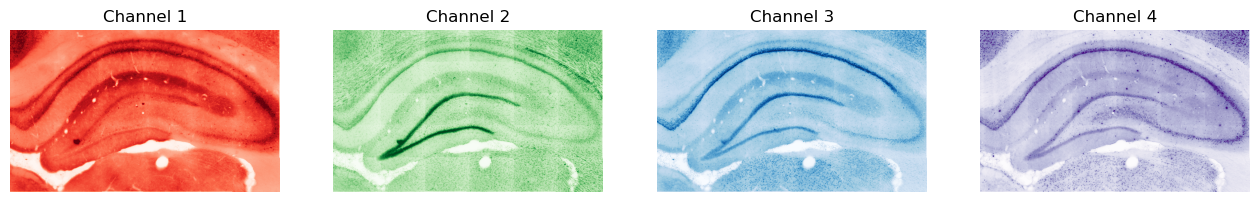

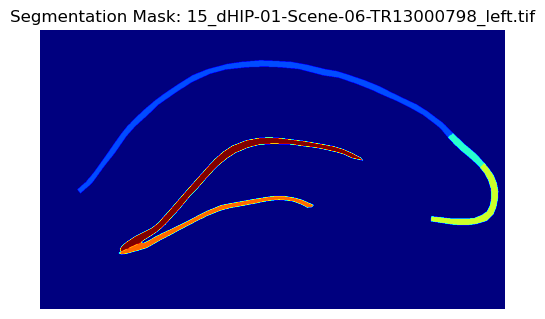

Displaying 4-channel image for: 18_dHIP-01-Scene-01-TR13000926_left.tif


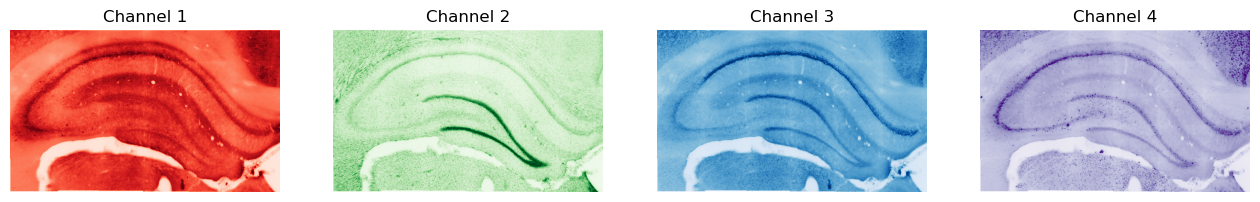

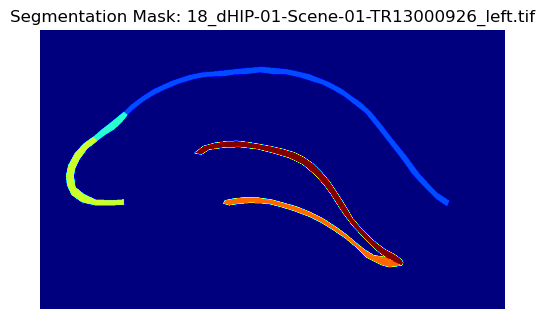

In [11]:
visualize_dataloader_samples(train_loader, masks_dir=masks_dir, num_show=2)

### 3.9) Build the model

In [12]:
model = build_model(
    device=device,
    num_classes=num_classes,
    num_channels=min_channels,
    load_model=False,
    model_path=None
)

### 3.10) Train the model

In [13]:
model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=num_classes,
    device=device,
    num_epochs=100,
    learning_rate=1e-4,
    save_checkpoint_path=path_to_model
)

Epoch 1/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 1.4678 | Val Loss: 1.1783 | Pixel Acc: 44.0357% | LR: 1.0e-04


Epoch 2/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 1.0009 | Val Loss: 0.8306 | Pixel Acc: 79.3294% | LR: 1.0e-04


Epoch 3/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 0.7986 | Val Loss: 0.7108 | Pixel Acc: 91.6121% | LR: 1.0e-04


Epoch 4/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 0.6680 | Val Loss: 0.6082 | Pixel Acc: 95.7478% | LR: 1.0e-04


Epoch 5/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 0.5707 | Val Loss: 0.5387 | Pixel Acc: 96.3905% | LR: 1.0e-04


Epoch 6/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 0.4871 | Val Loss: 0.4665 | Pixel Acc: 97.5540% | LR: 1.0e-04


Epoch 7/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7/100 | Train Loss: 0.4207 | Val Loss: 0.4051 | Pixel Acc: 97.2356% | LR: 1.0e-04


Epoch 8/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8/100 | Train Loss: 0.3618 | Val Loss: 0.3395 | Pixel Acc: 97.6628% | LR: 1.0e-04


Epoch 9/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9/100 | Train Loss: 0.2976 | Val Loss: 0.2705 | Pixel Acc: 97.6883% | LR: 1.0e-04


Epoch 10/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10/100 | Train Loss: 0.2553 | Val Loss: 0.2407 | Pixel Acc: 97.7420% | LR: 1.0e-04


Epoch 11/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 11/100 | Train Loss: 0.2247 | Val Loss: 0.2114 | Pixel Acc: 98.4297% | LR: 1.0e-04


Epoch 12/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 12/100 | Train Loss: 0.2039 | Val Loss: 0.1927 | Pixel Acc: 97.9397% | LR: 1.0e-04


Epoch 13/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 13/100 | Train Loss: 0.1918 | Val Loss: 0.1780 | Pixel Acc: 98.3312% | LR: 1.0e-04


Epoch 14/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 14/100 | Train Loss: 0.1700 | Val Loss: 0.1591 | Pixel Acc: 98.3536% | LR: 1.0e-04


Epoch 15/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 15/100 | Train Loss: 0.1528 | Val Loss: 0.1454 | Pixel Acc: 98.7732% | LR: 1.0e-04


Epoch 16/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 16/100 | Train Loss: 0.1406 | Val Loss: 0.1311 | Pixel Acc: 98.6414% | LR: 1.0e-04


Epoch 17/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 17/100 | Train Loss: 0.1320 | Val Loss: 0.1277 | Pixel Acc: 98.1373% | LR: 1.0e-04


Epoch 18/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 18/100 | Train Loss: 0.1252 | Val Loss: 0.1161 | Pixel Acc: 98.3486% | LR: 1.0e-04


Epoch 19/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 19/100 | Train Loss: 0.1146 | Val Loss: 0.1082 | Pixel Acc: 98.9535% | LR: 1.0e-04


Epoch 20/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 20/100 | Train Loss: 0.1054 | Val Loss: 0.0983 | Pixel Acc: 98.7515% | LR: 1.0e-04


Epoch 21/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 21/100 | Train Loss: 0.0994 | Val Loss: 0.0945 | Pixel Acc: 98.7803% | LR: 1.0e-04


Epoch 22/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 22/100 | Train Loss: 0.0943 | Val Loss: 0.0887 | Pixel Acc: 98.9554% | LR: 1.0e-04


Epoch 23/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 23/100 | Train Loss: 0.0883 | Val Loss: 0.0827 | Pixel Acc: 98.7520% | LR: 1.0e-04


Epoch 24/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 24/100 | Train Loss: 0.0848 | Val Loss: 0.0811 | Pixel Acc: 99.2312% | LR: 1.0e-04


Epoch 25/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 25/100 | Train Loss: 0.0814 | Val Loss: 0.0774 | Pixel Acc: 98.5089% | LR: 1.0e-04


Epoch 26/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 26/100 | Train Loss: 0.0747 | Val Loss: 0.0710 | Pixel Acc: 98.7852% | LR: 1.0e-04


Epoch 27/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 27/100 | Train Loss: 0.0719 | Val Loss: 0.0673 | Pixel Acc: 98.7862% | LR: 1.0e-04


Epoch 28/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 28/100 | Train Loss: 0.0682 | Val Loss: 0.0650 | Pixel Acc: 98.7153% | LR: 1.0e-04


Epoch 29/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 29/100 | Train Loss: 0.0654 | Val Loss: 0.0602 | Pixel Acc: 99.1413% | LR: 1.0e-04


Epoch 30/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 30/100 | Train Loss: 0.0632 | Val Loss: 0.0581 | Pixel Acc: 99.1837% | LR: 1.0e-04


Epoch 31/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 31/100 | Train Loss: 0.0632 | Val Loss: 0.0669 | Pixel Acc: 98.2918% | LR: 1.0e-04


Epoch 32/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 32/100 | Train Loss: 0.0673 | Val Loss: 0.0602 | Pixel Acc: 98.7376% | LR: 1.0e-04


Epoch 33/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 33/100 | Train Loss: 0.0605 | Val Loss: 0.0547 | Pixel Acc: 98.8058% | LR: 1.0e-04


Epoch 34/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 34/100 | Train Loss: 0.0574 | Val Loss: 0.0518 | Pixel Acc: 99.1534% | LR: 1.0e-04


Epoch 35/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 35/100 | Train Loss: 0.0533 | Val Loss: 0.0514 | Pixel Acc: 98.7588% | LR: 1.0e-04


Epoch 36/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 36/100 | Train Loss: 0.0524 | Val Loss: 0.0479 | Pixel Acc: 99.0648% | LR: 1.0e-04


Epoch 37/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 37/100 | Train Loss: 0.0501 | Val Loss: 0.0458 | Pixel Acc: 99.1084% | LR: 1.0e-04


Epoch 38/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 38/100 | Train Loss: 0.0510 | Val Loss: 0.0496 | Pixel Acc: 99.3186% | LR: 1.0e-04


Epoch 39/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 39/100 | Train Loss: 0.0516 | Val Loss: 0.0470 | Pixel Acc: 99.0967% | LR: 1.0e-04


Epoch 40/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 40/100 | Train Loss: 0.0495 | Val Loss: 0.0502 | Pixel Acc: 98.6617% | LR: 1.0e-04


Epoch 41/100:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 41/100 | Train Loss: 0.0468 | Val Loss: 0.0415 | Pixel Acc: 99.0663% | LR: 1.0e-04


Epoch 42/100:   0%|          | 0/22 [00:00<?, ?it/s]


Training interrupted. Saving checkpoint and returning model...
Checkpoint saved to: ./Models/hpc.pth


### 3.11) Visualize predicted regions of interest (ROIs)

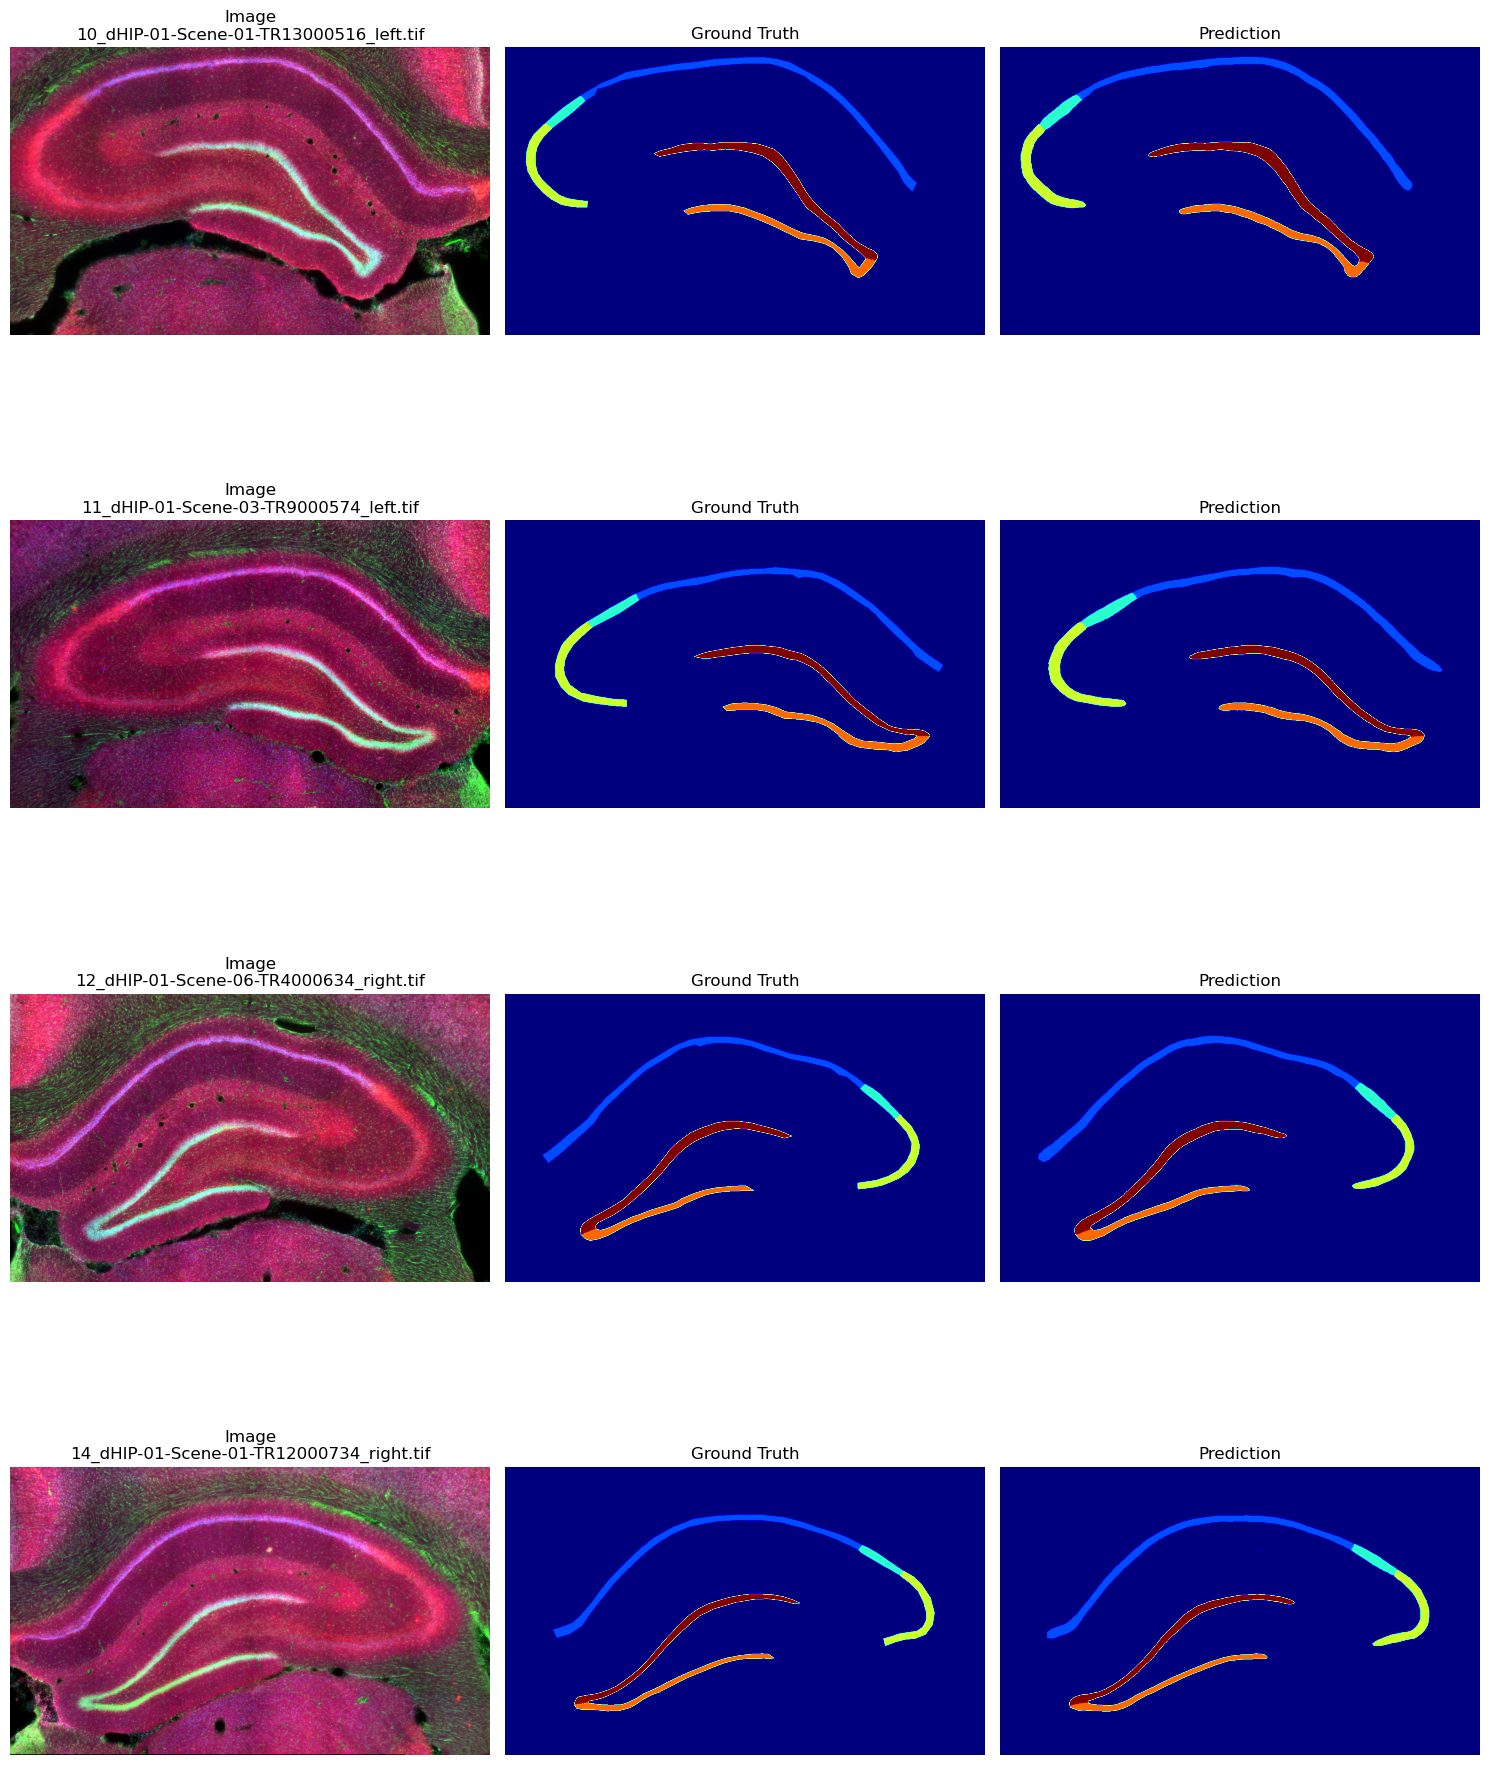

In [14]:
visualize_predictions(model, val_loader, num_show=4)

# 4) Generate new ROIs for unseen images

In [15]:
unseen_images_dir = "./Data"     # as an example, we use the same as the trainig folder
output_masks_dir  = "./Predicted_Masks"
output_rois_dir   = "./Predicted_ROIs"

In [16]:
ROI_names = {1: "CA1", 2: "CA2", 3: "CA3", 4: "DGl", 5: "DGu"}

Detected from unseen images: height=3117, width=5087, channels=4
Detected number of classes = 6 (including background).
Inference resizing to: 768 x 1280 (ratio=0.25)


Predicting:   0%|          | 0/106 [00:00<?, ?it/s]

Saved Fiji ROIs to: ./Predicted_ROIs\10_dHIP-01-Scene-01-TR13000516_left ROI.zip


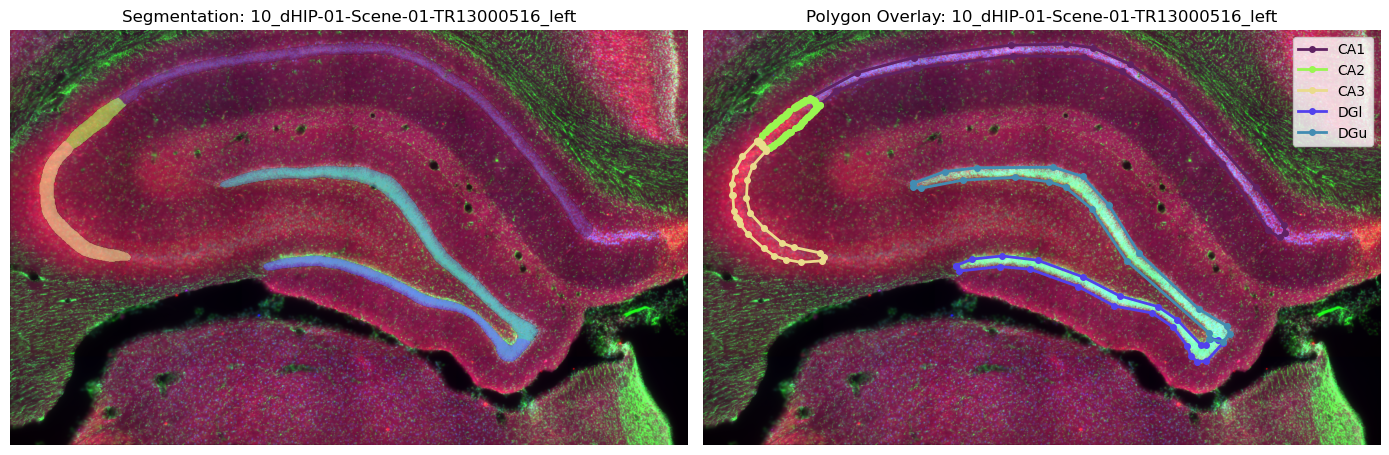

Saved Fiji ROIs to: ./Predicted_ROIs\10_dHIP-01-Scene-02-TR12000518_right ROI.zip


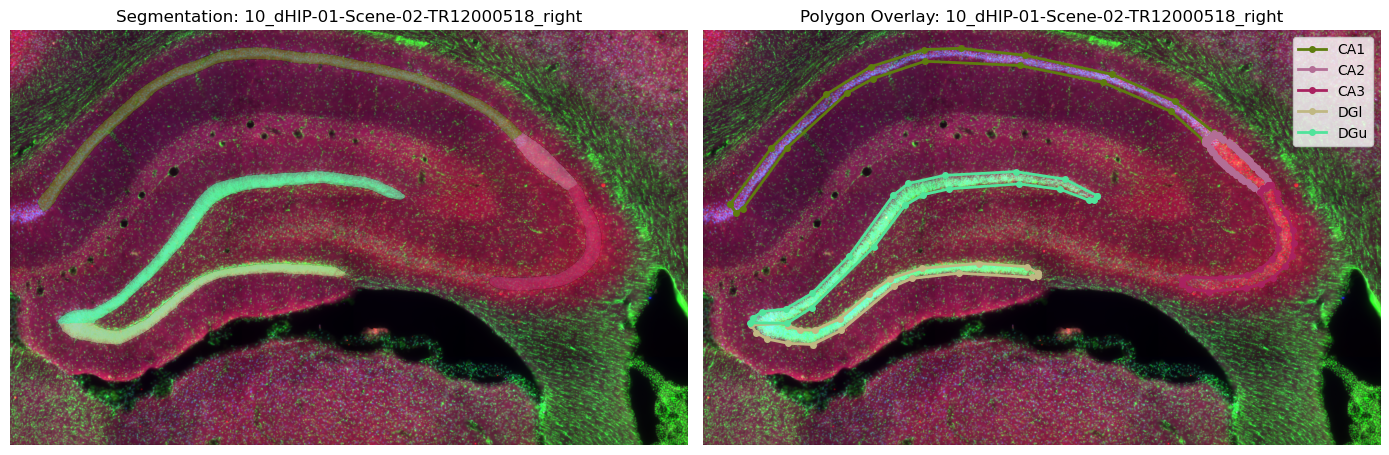

Saved Fiji ROIs to: ./Predicted_ROIs\10_dHIP-01-Scene-03-TR9000520_left ROI.zip


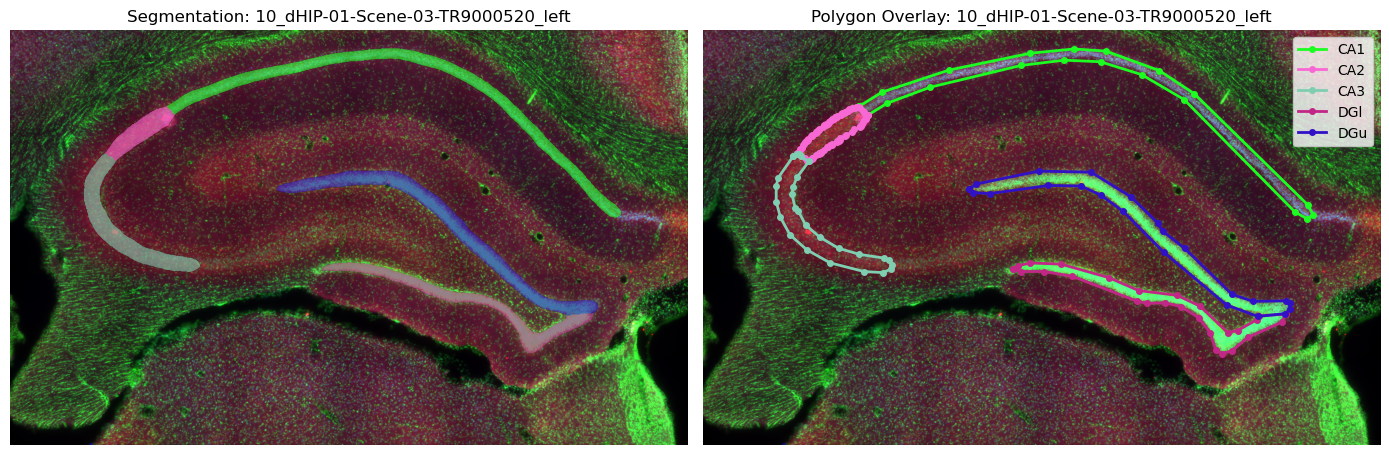

Saved Fiji ROIs to: ./Predicted_ROIs\10_dHIP-01-Scene-04-TR8000522_right ROI.zip


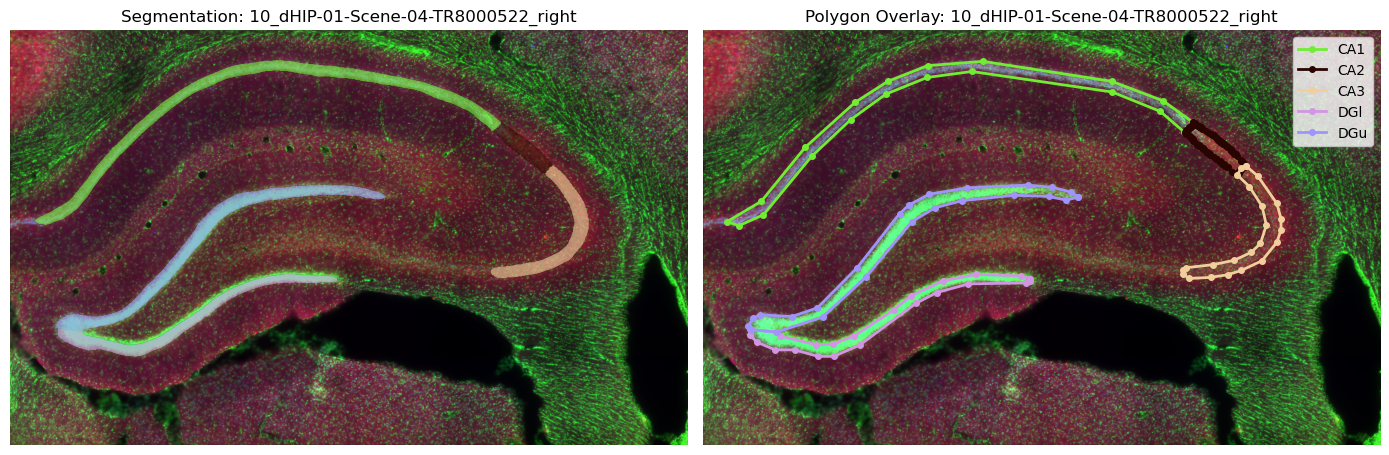

KeyboardInterrupt: 

In [21]:
predict_unseen_images(
    unseen_images_dir=unseen_images_dir,
    masks_dir=masks_dir,
    output_masks_dir=output_masks_dir,
    output_rois_dir=output_rois_dir,
    model_path=path_to_model,
    down_ratio=0.25,
    keep_largest=True,
    max_components=1,
    visualize=True,
    side_by_side_plot=True,
    label_colors=None,   # or {1: (255,0,0), 2: (0,255,0), ...}
    class_names=ROI_names,
    approx_factor=0.002
)